<a href="https://colab.research.google.com/github/rajlm10/Shoppster/blob/main/MLD_Project_MIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Nov 25 22:01:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    41W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uq sentence_transformers
!pip install transformers -qqq

     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 5.5 MB 26.5 MB/s 
     |████████████████████████████████| 1.3 MB 63.6 MB/s 
     |████████████████████████████████| 182 kB 80.8 MB/s 
     |████████████████████████████████| 7.6 MB 73.9 MB/s 


In [ ]:
!mkdir ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch import nn
from transformers import AutoFeatureExtractor, AutoModel
from torchvision import transforms
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SequentialSampler
import math
from PIL import Image
import torch.nn.functional as F
tqdm.pandas()

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -qq /content/fashion-product-images-small.zip 

 99% 558M/565M [00:03<00:00, 169MB/s]
100% 565M/565M [00:03<00:00, 160MB/s]


In [ ]:
train_dataframe = pd.read_csv('/content/drive/MyDrive/MLD/train_data.csv') 
val_dataframe = pd.read_csv('/content/drive/MyDrive/MLD/val_data.csv')
test_dataframe = pd.read_csv('/content/drive/MyDrive/MLD/test_data.csv') 

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224-in21k", pretrained=True, trainable=True, device=None):
        super().__init__()
        self.device = device
        self.model = AutoModel.from_pretrained(model_name)

        self.model.to(self.device)
        
        if trainable:
          for p in self.model.parameters():
              p.requires_grad = trainable

    def forward(self, image_inputs):
        image_inputs = {k:v.to(self.device) for k,v in image_inputs.items()}
        image_outputs = self.model(**image_inputs)
        image_embedding = image_outputs.pooler_output 
        return image_embedding

class TextEncoder(nn.Module):

    def __init__(self, model_name="sentence-transformers/all-mpnet-base-v2", trainable=True, device=None):
        super().__init__()
        self.device=device
        word_embedding_model = models.Transformer(model_name)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'mean')
        self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)
        self.model.to(self.device)

        if trainable:    
          for p in self.model.parameters():
              p.requires_grad = trainable

    def forward(self, text):
        attr_embedding = self.model.encode(text, convert_to_tensor=True, device=self.device)
        return attr_embedding

In [ ]:
class FashionDataset(Dataset):

    def __init__(self, root_dir, df):
        self.df = df
        self.root_dir = root_dir
        self.processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")    
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image_file = self.root_dir + "/" + self.df["image_id"][idx]
        positive = self.df['positive'][idx] 
        negative = self.df['negative'][idx] 
        image = Image.open(image_file).convert("RGB")

        encoding={}
        encoding["image_name"] = self.df["image_id"][idx]

        pixel_vals = self.processor(image, return_tensors="pt").pixel_values #The preprocessor will take care of resizing.
        encoding["anchor"] = {"pixel_values" : pixel_vals.squeeze(0)}

        encoding["pos"] = positive
        encoding["neg"] = negative
        

        return encoding

In [ ]:
train_dataset = FashionDataset(
                           root_dir='./images',
                           df=train_dataframe
                            )

dev_dataset = FashionDataset(
                           root_dir='./images',
                           df=val_dataframe
                            )

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 256
val_batch_size = 256
dataloader_train = DataLoader(train_dataset,
                              sampler=SequentialSampler(train_dataset), 
                              batch_size=batch_size)
dataloader_validation = DataLoader(dev_dataset, 
                                   sampler=SequentialSampler(dev_dataset), 
                                   batch_size=val_batch_size)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
for batch in dataloader_train:
  print(batch['anchor']['pixel_values'].shape)
  break


torch.Size([256, 3, 224, 224])


In [ ]:
class Network(nn.Module):

    def __init__(self, hyperparms=None):

        super(Network, self).__init__()  
        self.vision_projection = nn.Linear(hyperparms["vision_dim"], hyperparms["proj_dim"])
        self.text_projection = nn.Linear(hyperparms["text_dim"], hyperparms["proj_dim"])     
        self.dropout = nn.Dropout(0.1)

        device = hyperparms["device"]
        model_name = hyperparms["model_name"]
        self.image_encoder = ImageEncoder(model_name, device=device)


        self.text_encoder = TextEncoder(device=device)
        EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
        self.criterion = nn.TripletMarginWithDistanceLoss(margin=0.2, distance_function=EUCLIDEAN, reduction="mean")
        self.relu_f = nn.ReLU()

    def forward(self, batch):

        # Getting Image and Text Features
        image_emb = self.image_encoder(batch["anchor"])
        image_emb = torch.nn.functional.normalize(image_emb, p=2, dim=1)
        
        # Getting Image and Text Embeddings (with same dimension)
        image_emb = self.relu_f(self.vision_projection(image_emb))
        image_emb = self.dropout(image_emb)

        pos_emb = self.text_encoder(batch["pos"])
        pos_emb = torch.nn.functional.normalize(pos_emb, p=2, dim=1)
        pos_emb = self.relu_f(self.text_projection(pos_emb))
        pos_emb = self.dropout(pos_emb)

        neg_emb = self.text_encoder(batch["neg"])
        neg_emb = torch.nn.functional.normalize(neg_emb, p=2, dim=1)
        neg_emb = self.relu_f(self.text_projection(neg_emb))
        neg_emb = self.dropout(neg_emb)

        # Calculating the Loss
        loss = self.criterion(image_emb, pos_emb, neg_emb)       #Triplet Loss calculation
        return loss


In [ ]:
import random
from torch import nn
from tqdm.notebook import tqdm
import numpy as np
import requests


def evaluate(dataloader_val):

    model.eval()
    loss_val_total = 0
    
    for batch in dataloader_val:
        with torch.no_grad():        
            loss = model(batch)
            
        loss_val_total += loss.item()
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    return loss_val_avg

def train():

  train_history = open("./models/train_history.csv", "w")
  log_hdr  = "Epoch, train_loss, val_loss"
  train_history.write(log_hdr  + "\n")
  train_losses = []
  val_losses = []
  min_val_loss = -1
  epochs_no_improve = 0
  early_stopping_epoch = 1
  early_stop = False
  best_loss = float('inf')


  for epoch in tqdm(range(1, epochs+1)):

      model.train()
      loss_train_total = 0

      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

      for batch in progress_bar:
          model.zero_grad()

          loss = model(batch)
          loss_train_total += loss.item()
          loss.backward()
          optimizer.step()
          scheduler.step()

          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

      tqdm.write(f'\nEpoch {epoch}')
      loss_train_avg = loss_train_total/len(dataloader_train)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      val_loss = evaluate(dataloader_validation)
      tqdm.write(f'Validation loss: {val_loss}')

      if val_loss < best_loss:
          best_loss = val_loss
          tqdm.write('\nSaving best model')
          torch.save(model.state_dict(), f'./models/network_mim_epoch_{epoch}.model')          

      train_losses.append(loss_train_avg)
      val_losses.append(val_loss)
      log_str  = "{}, {}, {}".format(epoch, loss_train_avg, val_loss)
      train_history.write(log_str + "\n")

      if min_val_loss < 0:
          min_val_loss = val_loss
      else:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_epoch:
                early_stop = True
                break
            else:
                continue    


  if early_stop:
    print("Early Stopping activated at epoch -", epoch )
    print("Use the checkpoint at epoch - ", epoch - early_stopping_epoch)

  train_history.close()
  return train_losses, val_losses

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# To use Transformer for Vision 
model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
model.to(device)
print()

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Fri Nov 25 22:04:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |   2042MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW


optimizer = AdamW(model.parameters(),
                  lr=5e-5, 
                  weight_decay = 1e-5,
                  eps=1e-8
                  )
                  
                  
epochs = 2
train_steps= int((train_dataframe.shape[0] / batch_size) * epochs)
print("train_steps", train_steps)
warm_steps = int(train_steps * 0.1)
print("warm_steps", warm_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warm_steps,
                                            num_training_steps=train_steps)



train_steps 1843
warm_steps 184


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.07821238135066441
Validation loss: 0.05184409375591525

Saving best model


Epoch 2:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.046351052699469174
Validation loss: 0.044686719903658176

Saving best model


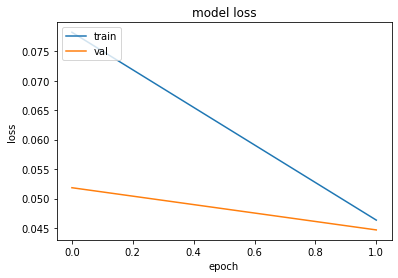

In [ ]:
import glob
import os
from matplotlib import pyplot as plt
torch.cuda.empty_cache()
!rm -rf ./models
!mkdir ./models
do_plot = True


#try:
train_losses, val_losses =  train()
if do_plot:
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!cp /content/models/network_mim_epoch_2.model /content/drive/MyDrive/MLD

In [ ]:
test_dataset = FashionDataset(root_dir='./images',df=test_dataframe)


test_batch_size = 512
dataloader_test = DataLoader(test_dataset, 
                                   sampler=SequentialSampler(test_dataset), 
                                   batch_size=test_batch_size)

model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_mim_epoch_2.model'))
model.to(device)

def get_image_embeddings():
    model.eval()
    test_image_embeddings = []
    image_names = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test):
            image_features = model.image_encoder(batch["anchor"])             
            image_names.extend(batch["image_name"])
            image_embeddings = model.vision_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    return image_names, torch.cat(test_image_embeddings)

image_names, image_embeddings = get_image_embeddings()

from sentence_transformers import util

def search(query, image_embeddings, img_names, k=101):
    query_emb = model.text_encoder(query)
    query_emb = model.text_projection(query_emb)
    hits = util.semantic_search(query_emb, image_embeddings, top_k=k)[0]
    return [img_names[hit['corpus_id']] for hit in hits]
        
def get_results(df):
    from collections import defaultdict
    attr2Image = defaultdict(list)
    attr2Pred_Image = defaultdict(list)
    actuals = []
    predictions = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        attr = row["positive"]    
        if attr not in attr2Image:
            attr2Image["attr"] = df[df.positive == attr]["image_id"].to_list()
        actuals.append(attr2Image["attr"])
        if attr not in attr2Pred_Image:
           attr2Pred_Image["attr"] = search(attr, image_embeddings, image_names)
           
        predictions.append(attr2Pred_Image["attr"])

    return actuals, predictions

actuals, predictions = get_results(test_dataframe)

#2 epochs
def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

def recall_at_k(k=1):
    results = []
    for actual, predicted in zip(actuals, predictions):
         results.append(recall(actual, predicted, k))
    return results         

R1 = recall_at_k(1)
R5 = recall_at_k(5)
R20 = recall_at_k(20)
R100 = recall_at_k(100)
Mean_R1 = sum(R1) / len(R1)
Mean_R5 = sum(R5) / len(R5)
Mean_R20 = sum(R20) / len(R20)
Mean_R100 = sum(R100)/ len(R100)
print(Mean_R1)
print(Mean_R5)
print(Mean_R20)
print(Mean_R100)

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3030 [00:00<?, ?it/s]

0.01053135313531353
0.04219141914191422
0.12301980198019792
0.339379537953795


## 4 epochs

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train_steps 1843
warm_steps 184


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.03946993156152408
Validation loss: 0.03713609303893714

Saving best model


Epoch 2:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.03057539829309553
Validation loss: 0.033803972431683336

Saving best model


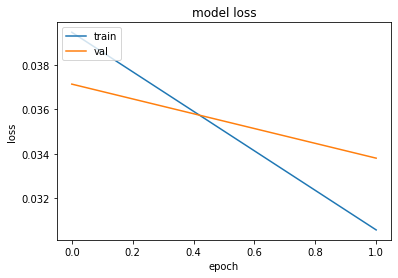

In [ ]:
torch.cuda.empty_cache()
model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_mim_epoch_2.model'))
model.to(device)


optimizer = AdamW(model.parameters(),
                  lr=5e-5, 
                  weight_decay = 1e-5,
                  eps=1e-8
                  )
                  
                  
epochs = 2
train_steps= int((train_dataframe.shape[0] / batch_size) * epochs)
print("train_steps", train_steps)
warm_steps = int(train_steps * 0.1)
print("warm_steps", warm_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warm_steps,
                                            num_training_steps=train_steps)

torch.cuda.empty_cache()
!rm -rf ./models
!mkdir ./models
do_plot = True


#try:
train_losses, val_losses =  train()
if do_plot:
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [ ]:
!cp /content/models/network_mim_epoch_4.model /content/drive/MyDrive/MLD

In [ ]:
test_dataset = FashionDataset(root_dir='./images',df=test_dataframe)


test_batch_size = 512
dataloader_test = DataLoader(test_dataset, 
                                   sampler=SequentialSampler(test_dataset), 
                                   batch_size=test_batch_size)

model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_mim_epoch_4.model'))
model.to(device)

def get_image_embeddings():
    model.eval()
    test_image_embeddings = []
    image_names = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test):
            image_features = model.image_encoder(batch["anchor"])             
            image_names.extend(batch["image_name"])
            image_embeddings = model.vision_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    return image_names, torch.cat(test_image_embeddings)

image_names, image_embeddings = get_image_embeddings()

from sentence_transformers import util

def search(query, image_embeddings, img_names, k=101):
    query_emb = model.text_encoder(query)
    query_emb = model.text_projection(query_emb)
    hits = util.semantic_search(query_emb, image_embeddings, top_k=k)[0]
    return [img_names[hit['corpus_id']] for hit in hits]
        
def get_results(df):
    from collections import defaultdict
    attr2Image = defaultdict(list)
    attr2Pred_Image = defaultdict(list)
    actuals = []
    predictions = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        attr = row["positive"]    
        if attr not in attr2Image:
            attr2Image["attr"] = df[df.positive == attr]["image_id"].to_list()
        actuals.append(attr2Image["attr"])
        if attr not in attr2Pred_Image:
           attr2Pred_Image["attr"] = search(attr, image_embeddings, image_names)
           
        predictions.append(attr2Pred_Image["attr"])

    return actuals, predictions

actuals, predictions = get_results(test_dataframe)

#4 epochs
def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

def recall_at_k(k=1):
    results = []
    for actual, predicted in zip(actuals, predictions):
         results.append(recall(actual, predicted, k))
    return results         

R1 = recall_at_k(1)
R5 = recall_at_k(5)
R20 = recall_at_k(20)
R100 = recall_at_k(100)
Mean_R1 = sum(R1) / len(R1)
Mean_R5 = sum(R5) / len(R5)
Mean_R20 = sum(R20) / len(R20)
Mean_R100 = sum(R100)/ len(R100)
print(Mean_R1)
print(Mean_R5)
print(Mean_R20)
print(Mean_R100)

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3030 [00:00<?, ?it/s]

0.012864686468646866
0.0451815181518152
0.13692409240924094
0.37480198019801997


#6 epochs

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train_steps 1843
warm_steps 184


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.02742294079993817
Validation loss: 0.03151630351705284

Saving best model


Epoch 2:   0%|          | 0/922 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.020863946564616778
Validation loss: 0.029466490004340123

Saving best model


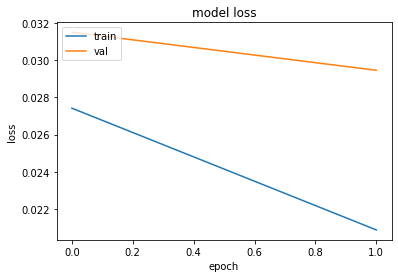

In [ ]:
model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_mim_epoch_4.model'))
model.to(device)


optimizer = AdamW(model.parameters(),
                  lr=5e-5, 
                  weight_decay = 1e-5,
                  eps=1e-8
                  )
                  
                  
epochs = 2
train_steps= int((train_dataframe.shape[0] / batch_size) * epochs)
print("train_steps", train_steps)
warm_steps = int(train_steps * 0.1)
print("warm_steps", warm_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warm_steps,
                                            num_training_steps=train_steps)

torch.cuda.empty_cache()
!rm -rf ./models
!mkdir ./models
do_plot = True


#try:
train_losses, val_losses =  train()
if do_plot:
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [ ]:
!cp /content/models/network_mim_epoch_6.model /content/drive/MyDrive/MLD

In [ ]:
test_dataset = FashionDataset(root_dir='./images',df=test_dataframe)


test_batch_size = 512
dataloader_test = DataLoader(test_dataset, 
                                   sampler=SequentialSampler(test_dataset), 
                                   batch_size=test_batch_size)

model = Network(hyperparms={"device": device, "model_name": "/content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_mim_epoch_6.model'))
model.to(device)

def get_image_embeddings():
    model.eval()
    test_image_embeddings = []
    image_names = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test):
            image_features = model.image_encoder(batch["anchor"])             
            image_names.extend(batch["image_name"])
            image_embeddings = model.vision_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    return image_names, torch.cat(test_image_embeddings)

image_names, image_embeddings = get_image_embeddings()

from sentence_transformers import util

def search(query, image_embeddings, img_names, k=101):
    query_emb = model.text_encoder(query)
    query_emb = model.text_projection(query_emb)
    hits = util.semantic_search(query_emb, image_embeddings, top_k=k)[0]
    return [img_names[hit['corpus_id']] for hit in hits]
        
def get_results(df):
    from collections import defaultdict
    attr2Image = defaultdict(list)
    attr2Pred_Image = defaultdict(list)
    actuals = []
    predictions = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        attr = row["positive"]    
        if attr not in attr2Image:
            attr2Image["attr"] = df[df.positive == attr]["image_id"].to_list()
        actuals.append(attr2Image["attr"])
        if attr not in attr2Pred_Image:
           attr2Pred_Image["attr"] = search(attr, image_embeddings, image_names)
           
        predictions.append(attr2Pred_Image["attr"])

    return actuals, predictions

actuals, predictions = get_results(test_dataframe)

#2 epochs
def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = round(len(act_set & pred_set) / float(len(act_set)), 2)
    return result

def recall_at_k(k=1):
    results = []
    for actual, predicted in zip(actuals, predictions):
         results.append(recall(actual, predicted, k))
    return results         

R1 = recall_at_k(1)
R5 = recall_at_k(5)
R20 = recall_at_k(20)
R100 = recall_at_k(100)
Mean_R1 = sum(R1) / len(R1)
Mean_R5 = sum(R5) / len(R5)
Mean_R20 = sum(R20) / len(R20)
Mean_R100 = sum(R100)/ len(R100)
print(Mean_R1)
print(Mean_R5)
print(Mean_R20)
print(Mean_R100)

Some weights of the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 were not used when initializing ViTModel: ['decoder.0.bias', 'decoder.0.weight', 'vit.embeddings.mask_token']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at /content/drive/MyDrive/MLD/MIM/mim_4_epochs/checkpoint-18732 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3030 [00:00<?, ?it/s]

0.014184818481848192
0.05475247524752475
0.150188118811881
0.3927392739273924
